In [1]:
!pip install opencv-python
!pip install tqdm
!pip install imgaug
!pip install imageio
!pip install tensorflow
!pip install labelImg

In [1]:
import os
import shutil
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

<b> Configuration des Ensembles de Données pour Améliorer les Performances

In [2]:
# Chemins d'accès
base_dir = './dataset/'
src_images_dir = './dataset/images/'
src_labels_dir = './dataset/labels/'

In [3]:
# Paramètres de base pour le chargement des images
img_height, img_width = 64, 64
batch_size = 64

In [4]:
# Lire les noms des fichiers
image_paths = [os.path.join(src_images_dir, fname) for fname in os.listdir(src_images_dir) if fname.endswith('.jpg')]
label_paths = [os.path.join(src_labels_dir, fname) for fname in os.listdir(src_labels_dir) if fname.endswith('.txt')]

# Assurer que les listes sont triées pour correspondre les images aux labels
image_paths.sort()
label_paths.sort()

In [5]:
len(image_paths)

2516

In [6]:
# Fonction permettant d'analyser les coordonnées de la boîte de délimitation à partir d'un fichier texte
def parse_bounding_boxes(text_file_paths):
    bounding_boxes = {}
    for text_file in tqdm(text_file_paths,total=len(text_file_paths)):
        # Déterminer le chemin d'accès au fichier image correspondant
        image_file = text_file.replace('.txt', '.jpg')
        image_file1 = image_file.replace('labels', 'images')
        with open(text_file, 'r') as file:
            data = file.read()
            # Chaque ligne du fichier est une boîte de délimitation distincte.
            boxes = data.strip().split('\n')
            # Analyse de chaque coordonnée de la boîte
            box_coords = [tuple(map(float, box.split())) for box in boxes]
            bounding_boxes[image_file1] = box_coords
    return bounding_boxes

# Appel de la fonction avec nos fichiers texte d'exemple
bounding_boxes = parse_bounding_boxes(label_paths)
bounding_boxes

100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:08<00:00, 298.21it/s]


{'./dataset/images/5_10_jpg.rf.5639f7a69885c595fc4b54e55dbf5148.jpg': [()],
 './dataset/images/5_11_jpg.rf.99ee6f27d5d5f353e00506003993302a.jpg': [()],
 './dataset/images/5_12_jpg.rf.f46713998d4579eabe3baf01d0bc605c.jpg': [()],
 './dataset/images/5_13_jpg.rf.d4959906ae25dc3b28e2e43553764b1c.jpg': [()],
 './dataset/images/5_14_jpg.rf.af89c1ce48edc27397830962d43d5c6a.jpg': [()],
 './dataset/images/5_15_jpg.rf.02c45be3c76c4201f24dd386e060ed8c.jpg': [()],
 './dataset/images/5_16_jpg.rf.ac71b8803fe5c99c3fc1e6867351c0bb.jpg': [()],
 './dataset/images/5_17_jpg.rf.0611b10e50517e4323c47fc36301167c.jpg': [()],
 './dataset/images/5_22_jpg.rf.368e2a41bf84be83076f603939cbd052.jpg': [()],
 './dataset/images/5_23_jpg.rf.b98dce2a37d470d921751909d8030cee.jpg': [()],
 './dataset/images/5_24_jpg.rf.36c0b527bff3e31a8effc6d45c8be54a.jpg': [()],
 './dataset/images/5_25_jpg.rf.0a5f2cffb167f51cdfbd781fa2c84799.jpg': [()],
 './dataset/images/5_26_jpg.rf.56a14e695c9d4f114bc7695b4eeee5c4.jpg': [()],
 './dataset/

In [8]:
def extract_targets(image_paths, bounding_boxes):
    data_images = []
    data_labels = []
    
    for image_path in tqdm(image_paths,total=len(image_paths)):
        # Vérifie si des boîtes englobantes existent pour cette image
        if image_path in bounding_boxes:
            for box_info in bounding_boxes[image_path]:
                if not box_info:
                    box = [1.0, 0.0, 0.0, 0.0, 0.0]
                else:
                    box = list(box_info)  # box est une liste: [classe, x_center, y_center, width, height]
                data_labels.append(box)
                data_images.append(image_path)
        else:
            # Si aucune boîte n'est trouvée
            box = [1.0, 0.0, 0.0, 0.0, 0.0]
            data_images.append(image_path)
            data_labels.append(box)
    return data_images, data_labels


In [9]:
images, labels = extract_targets(image_paths, bounding_boxes)
images = np.array(images)
labels = np.array(labels)
images.shape,labels.shape

100%|█████████████████████████████████████████████████████████████████████████| 2516/2516 [00:00<00:00, 2516782.46it/s]


((2636,), (2636, 5))

In [10]:
# Créer un générateur de données
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

def load_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img /= 255.0
    return img

In [11]:
# Générateur de données
def data_generator(files, labels, batch_size):
    while True:
        for start in range(0, len(files), batch_size):
            end = min(start + batch_size, len(files))
            batch_files = files[start:end]
            batch_labels = labels[start:end]
            images = np.array([load_image(f) for f in batch_files])
            yield images, np.array(batch_labels)

In [12]:
# Division des données
train_files, val_files, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=101)

In [13]:
# Affichage de la taille des données séparées pour vérification
train_files.shape,train_labels.shape,val_files.shape,val_labels.shape

((2108,), (2108, 5), (528,), (528, 5))

In [14]:
# Générateurs
train_generator = data_generator(train_files, train_labels, batch_size)
val_generator = data_generator(val_files, val_labels, batch_size)
train_generator

<generator object data_generator at 0x000002643D4E1A20>

<b> Construction du modele

In [27]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, Concatenate
from tensorflow.keras.models import Model

def create_detection_model(input_shape):
    # Couche d'entrée
    inputs = Input(shape=input_shape)

    # Base convolutive
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)

    # Détection de présence d'accident
    presence = Dense(1, activation='sigmoid', name='presence')(x)

    # Boîtes englobantes - coordonnées et taille
    boxes = Dense(4, activation='sigmoid', name='boxes')(x)

    # Fusion des sorties
    # Multiplication conditionnelle : les prédictions de boîte sont valides uniquement si `presence` indique un accident
    outputs = Concatenate()([presence, boxes])

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [28]:
def custom_loss_function(y_true, y_pred):
    # Séparation des étiquettes de classification et de boîte englobante
    classification_true = y_true[:, 0]
    boxes_true = y_true[:, 1:]

    classification_pred = y_pred[:, 0]
    boxes_pred = y_pred[:, 1:]

    # Calcul de la perte de classification - Binary Crossentropy
    classification_loss = tf.keras.losses.binary_crossentropy(classification_true, classification_pred)

    # Création d'un masque pour la condition
    mask = tf.cast(tf.expand_dims(classification_true, -1), tf.float32)

    # Calcul de la perte de localisation - Mean Squared Error
    # Utilisez seulement les données de localisation lorsque l'accident est présent
    localization_loss = tf.keras.losses.mean_squared_error(boxes_true, boxes_pred) * mask

    # Moyenne sur les boîtes pour éviter de sommer les pertes de tous les éléments
    localization_loss = tf.reduce_mean(localization_loss, axis=-1)  # Moyenne sur la dimension des boîtes

    # Somme des pertes de classification et de localisation
    total_loss = classification_loss + localization_loss
    return total_loss


In [29]:
# Paramètres
input_shape = (img_height, img_width, 3)  # Exemple de dimension d'entrée
model = create_detection_model(input_shape)

In [30]:
from tensorflow.keras.optimizers import SGD, Adam
# Compilation du modèle
model.compile(
    optimizer=SGD(learning_rate=0.003, momentum=0.8),
    loss=custom_loss_function,
    metrics=['accuracy']
)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 32)        │             896 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_2 (Flatten)           │ (None, 262144)            │               0 │ conv2d_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ presence (Dense)              │ (None, 1)                 │         262,145 │ flatten_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ boxes (Dense)                 │ (None, 4)                 │       1,048,580 │ flatten_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 5)                 │               0 │ presence[0][0],            │
│                               │                           │                 │ boxes[0][0]                │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,330,117 (5.07 MB)

 Trainable params: 1,330,117 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Entraînement
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_files),
    epochs=2,
    validation_data=val_generator,
    validation_steps=len(val_files),
    verbose=1
)

Epoch 1/2
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 757s 358ms/step - accuracy: 0.6237 - loss: 0.4623 - val_accuracy: 0.6384 - val_loss: 0.8515
Epoch 2/2
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 849s 403ms/step - accuracy: 0.8941 - loss: 0.0406 - val_accuracy: 0.6247 - val_loss: 1.1605


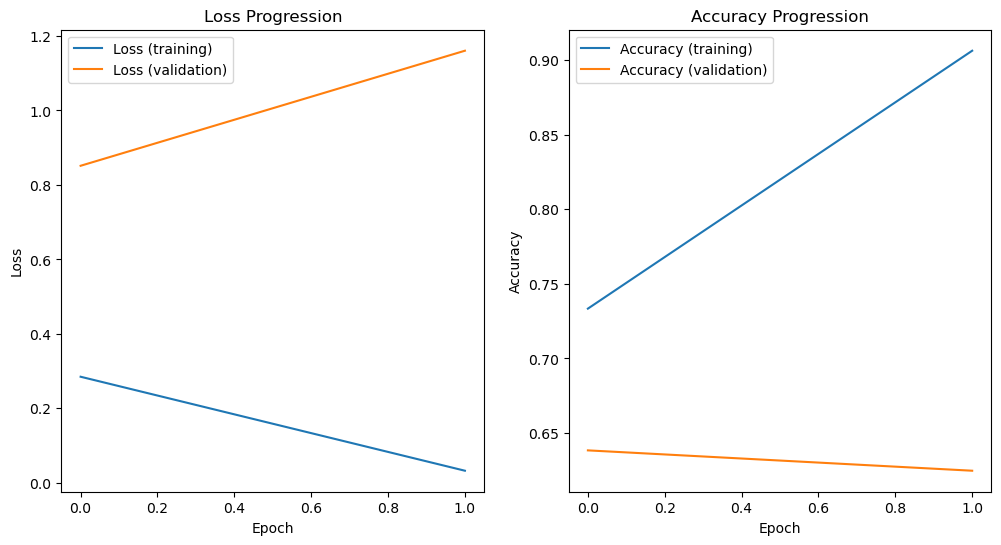

In [32]:
# Afficher les courbes de perte
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (training)')
plt.plot(history.history['val_loss'], label='Loss (validation)')
plt.title('Loss Progression')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Afficher les courbes de précision si elles sont disponibles
if 'accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy (training)')
    plt.plot(history.history['val_accuracy'], label='Accuracy (validation)')
    plt.title('Accuracy Progression')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plt.show()


In [33]:
# Évaluation
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation accuracy: {val_acc*100:.2f}%')

1742020/Unknown 873324s 501ms/step - accuracy: 0.6235 - loss: 1.1604

KeyboardInterrupt: 

In [38]:
import tensorflow.keras.preprocessing.image as image
# Faire une prédiction sur une nouvelle image
def load_and_prepare_image(filepath):
    img = load_image(filepath)
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    return img_tensor

new_image = load_and_prepare_image('./dataset/aug_18_test4_10_jpg.rf.b97252d8abc30ed694e10a0035a7a011.jpg')
prediction = model.predict(new_image)
predicted_class = np.argmax(prediction)
prediction,predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


(array([[0.5294544 , 0.3363838 , 0.33580765, 0.31796467, 0.31943014]],
       dtype=float32),
 0)

In [40]:
model_path = './cnn1.keras'
model.save(model_path)
print("Model saved at:", model_path)

Model saved at: ./cnn1.keras
